In [1]:
# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import pickle

***
Given the insights in the previous notebook could be headlined as "Ideal workload stays", it raises the question.  Is it possible to balance the workload?
***

<br><br>

### Objective: Balance The Workload

We will attempt to balance the workload by offloading overworked employees to underworked.

### Precondition 1: Spare Hours

##### Question: Are there enough hours among the underworked, to absorb the overworked by department?

In [2]:
# reload unscaled data
df = pd.read_csv('./data/HR_data.csv')

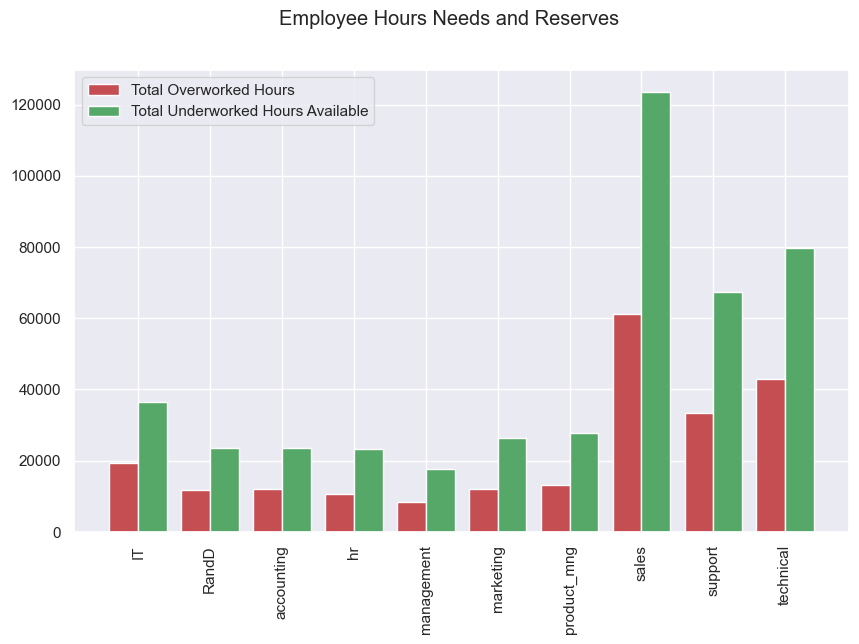

In [3]:
max_healthy_hours = 216

df['max_healthy_hours']   = max_healthy_hours
df['num_unhealthy_hours'] =  df[['max_healthy_hours', 'average_monthly_hours']].max(axis=1) - max_healthy_hours
df['available_hours'] = max_healthy_hours - df[['max_healthy_hours', 'average_monthly_hours']].min(axis=1)


fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10, 6))


unhlth_hrs_by_dpt = df.groupby('department')['num_unhealthy_hours'].sum()
undrwk_hrs_by_dpt = df.groupby('department')['available_hours'].sum()

assert np.all(unhlth_hrs_by_dpt.index == undrwk_hrs_by_dpt.index)

width = .4
space = width / 2

ax.bar([n-space for n, i in enumerate(unhlth_hrs_by_dpt.index)], unhlth_hrs_by_dpt.values, 
        color='C3', width=width, label='Total Overworked Hours')
ax.bar([n+space for n, i in enumerate(unhlth_hrs_by_dpt.index)], undrwk_hrs_by_dpt.values,
        color='C2', width=width, label='Total Underworked Hours Available')

ax.set_xticks(ticks=range(len(unhlth_hrs_by_dpt.index)),
                labels=unhlth_hrs_by_dpt.index,
                rotation=90)

plt.suptitle('Employee Hours Needs and Reserves')
plt.legend()
plt.show()

##### Answer: Yes, in every department the is more underworked time than overworked.

<br><br><br><br>

### Precondition 2: Spare Projects

##### Question: Are there enough projects among the underworked, to absorb the overworked by department?

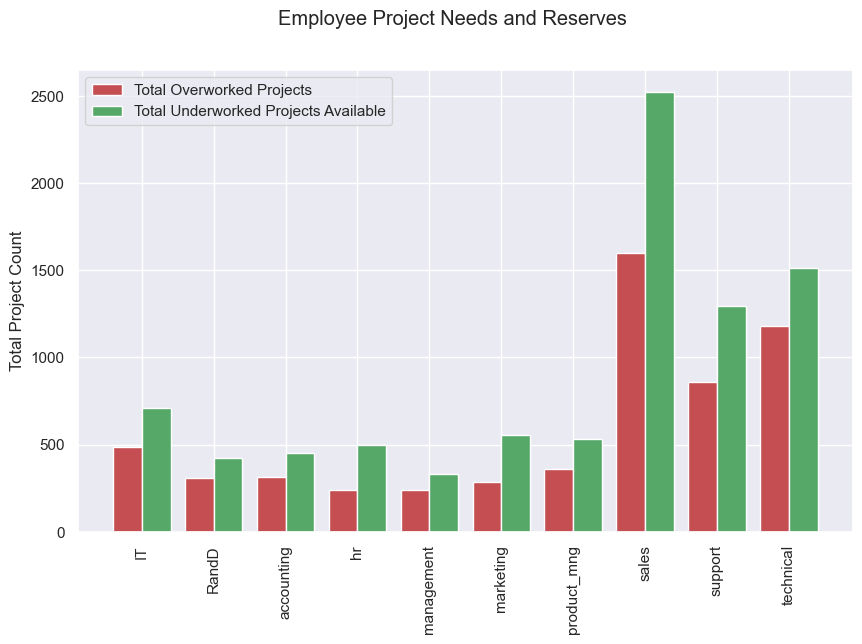

In [4]:
max_healthy_projects = 4

df['max_healthy_projects']   = max_healthy_projects
df['num_unhealthy_projects'] =  df[['max_healthy_projects', 'number_projects']].max(axis=1) - max_healthy_projects
df['available_projects']     = max_healthy_projects - df[['max_healthy_projects', 'number_projects']].min(axis=1)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10, 6))

unhlth_prj_by_dpt = df.groupby('department')['num_unhealthy_projects'].sum()
undrwk_prj_by_dpt = df.groupby('department')['available_projects'].sum()

assert np.all(unhlth_prj_by_dpt.index == undrwk_prj_by_dpt.index)

width = .4
space = width / 2

ax.bar([n-space for n, i in enumerate(unhlth_prj_by_dpt.index)], unhlth_prj_by_dpt.values, 
        color='C3', width=width, label='Total Overworked Projects')
ax.bar([n+space for n, i in enumerate(undrwk_prj_by_dpt.index)], undrwk_prj_by_dpt.values,
        color='C2', width=width, label='Total Underworked Projects Available')

ax.set_xticks(ticks=range(len(unhlth_hrs_by_dpt.index)),
                labels=unhlth_hrs_by_dpt.index,
                rotation=90)
ax.set(ylabel=('Total Project Count'))

plt.suptitle('Employee Project Needs and Reserves')
plt.legend()
plt.show()

##### Answer: Yes, in every department the is more underworked projects than overworked.

<br><br><br><br>

### Model Solution

##### Step 1: Redistribute Hours

The following function redistribues hours from the overworked to the underworked, staying within department and salary range, prioritizing higher evaluated employees.

In [5]:
def redistribute_work(df, max_hours=216, max_proj=4):
    # sort to distribute work to best performers
    df_copy = df.copy()
    df_copy.sort_values('last_evaluation', ascending=False, inplace=True)

    # distribute work to same department
    for department in df_copy['department'].unique():
        
        # distribute work to same salary level
        for salary in df_copy['salary'].unique():
            
            select = (df_copy['salary'] == salary) & (df_copy['department'] == department)
            
            # distribute hours and projects
            for feature, max_val in zip(['average_monthly_hours', 'number_projects'], [max_hours, max_proj]):

                # get overage
                total_over_value = np.sum([max(0, val-max_val) for val in df_copy.loc[select, feature]])

                # clear overage
                df_copy.loc[select, feature] = df_copy.loc[select, feature].clip(upper=max_val)

                # distribute overage
                for index in df_copy.loc[select].index:
                    
                    # see if employee is underworked
                    if df_copy.loc[index, feature] < max_val:
                        
                        # calculate how much underworked
                        avail_value = max_val - df_copy.loc[index, feature]
                        
                        # logic to distribute less on the final distribution
                        if total_over_value > avail_value:
                            
                            # distribute max work
                            df_copy.loc[index, feature] += avail_value
                            
                            # deduct distribution from total_over_value
                            total_over_value -= avail_value
                            
                        # final distribution
                        else:
                            
                            # distribute remaining work
                            df_copy.loc[index, feature] += total_over_value
                            
                            # clear remaining distributions (a symbolic step)
                            total_over_value = 0
                            break

                    # raise if not enough available for distribution
                    if index == df_copy.loc[select].index[-1]:
                        print(department, salary, total_over_value, feature)
                        df_copy.loc[index, feature] += total_over_value
                        
                        
    return df_copy


df_ideal = redistribute_work(df, max_hours=210, max_proj=4)

# check nothing was added, only reorganized
for feature in ['average_monthly_hours', 'number_projects']:
    old_totals = df_ideal.groupby(['department', 'salary'])[feature].sum()
    new_totals = df.groupby(['department', 'salary'])[feature].sum()
    assert np.all(old_totals == new_totals)


management medium 2 number_projects


All hours and projects were able to be redistributed within our "healthy" range despite 2 projects the medium salary management department.

##### Step 2: Model Change

Using the previous model built predict how this redistribution of hours and projects could impact employee retention.

In [7]:
# load model
with open('./pkl/xgb_best.pkl', 'rb') as file:
    model = pickle.load(file)

In [8]:
model_features = ['satisfaction_level', 'last_evaluation', 'number_projects',
       'average_monthly_hours', 'years_with_company', 'work_accident',
       'promotion_last_5years', 'department', 'salary']

X_ideal = pd.get_dummies(df_ideal[model_features], drop_first=True)
y_ideal = model.predict(X_ideal)

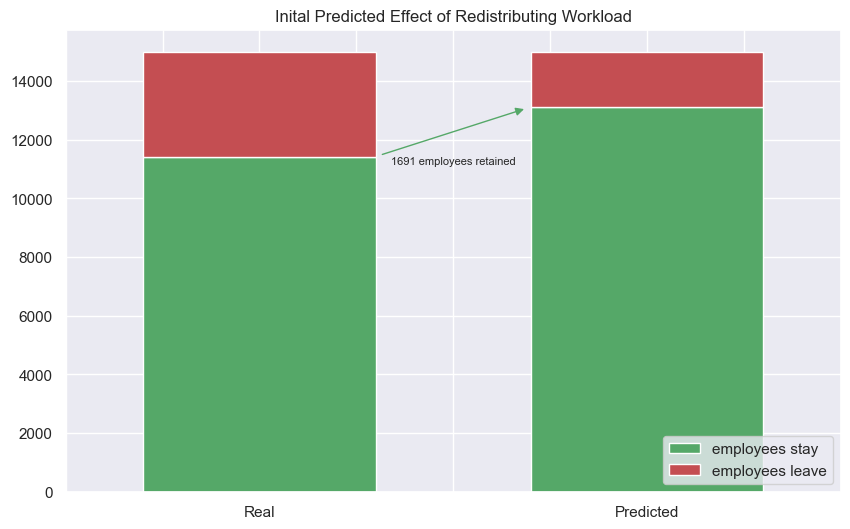

In [9]:
current_leave = df['left'].sum()
ideal_leave   = y_ideal.sum()

current_stay  = len(df) - current_leave
ideal_stay    = len(y_ideal) - ideal_leave

num_saved = df['left'].sum() - y_ideal.sum()

fig, ax = plt.subplots(1, 1, figsize=(10,6))

width = .6
ax.bar([0, 1], [current_stay, ideal_stay], color='C2', width=width, label='employees stay')
ax.bar([0, 1], [current_leave, ideal_leave], bottom=[current_stay, ideal_stay], width=width, color='C3',
       label='employees leave')
ax.set_title('Inital Predicted Effect of Redistributing Workload')
ax.set(xlim=[-.5, 1.5])
xticks = ax.get_xticks()
ax.set(xticks=xticks, xticklabels=['','','Real','','','','Predicted','',''])
ax.annotate('', (.3, current_stay), xytext=(.7, ideal_stay),
            arrowprops={'arrowstyle':'<|-', 'facecolor':'C2','edgecolor':'C2', 'shrinkA':5, 'shrinkB':5})
ax.text(.5, current_stay, f'{num_saved} employees retained', ha='center', va='top', fontsize=8)
ax.legend(loc='lower right')
plt.show()

##### Great Results!  Model predicts that with these new changes 1,691 employees could be retained!

<br><br><br>

### Good News:

This above model was assuming satisfaction levels would stay the same for all employees, very likley they would be effected.  What if we predict without considering satisfaction levels?

In [10]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [11]:
# reload unscaled data
model_data = pd.read_csv('./data/HR_data_for_model.csv', index_col=0)

# seperate inputs and targets
X = model_data.drop(columns=['left'])
y = model_data['left']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, stratify=y)

In [12]:
# init XGBoost with best optimized hyperparameters

model_params = {
    'learning_rate' : 0.01,
    'max_depth'     : 7,
    'n_estimators'  : 951
}
model = XGBClassifier(**model_params)

# train on unscaled data
model.fit(X_train.drop(columns=['satisfaction_level']), y_train)

# test on unscaled data
y_pred = model.predict(X_test.drop(columns=['satisfaction_level']))

# print results
print('XGBoost Unscaled Data F1 Score:', round(f1_score(y_test, y_pred), 3))

XGBoost Unscaled Data F1 Score: 0.941


##### Even without `satisfaction_level` as a feature, the model still performs well.

In [13]:
# predict without considering satisfaction levels
model_features = ['last_evaluation', 'number_projects',
       'average_monthly_hours', 'years_with_company', 'work_accident',
       'promotion_last_5years', 'department', 'salary']

X_ideal = pd.get_dummies(df_ideal[model_features], drop_first=True)
y_ideal = model.predict(X_ideal)

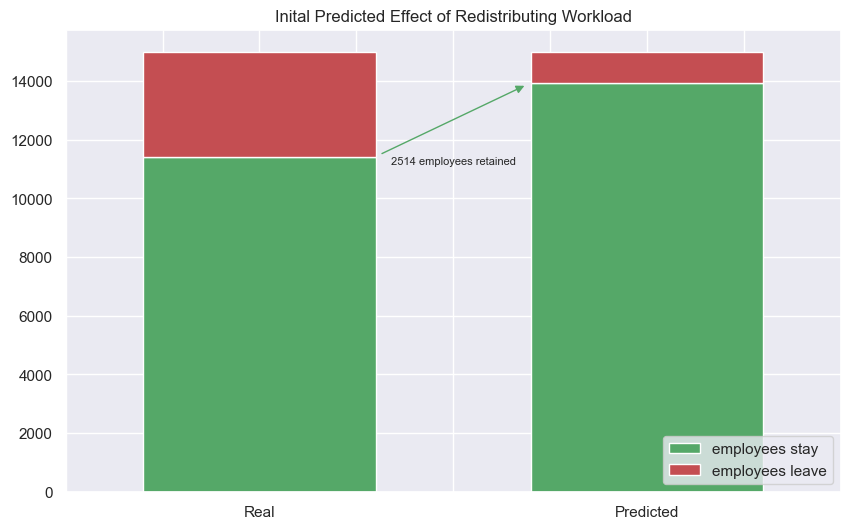

In [14]:
current_leave = df['left'].sum()
ideal_leave   = y_ideal.sum()

current_stay  = len(df) - current_leave
ideal_stay    = len(y_ideal) - ideal_leave

num_saved = df['left'].sum() - y_ideal.sum()

fig, ax = plt.subplots(1, 1, figsize=(10,6))

width = .6
ax.bar([0, 1], [current_stay, ideal_stay], color='C2', width=width, label='employees stay')
ax.bar([0, 1], [current_leave, ideal_leave], bottom=[current_stay, ideal_stay], width=width, color='C3',
       label='employees leave')
ax.set_title('Inital Predicted Effect of Redistributing Workload')
ax.set(xlim=[-.5, 1.5])
xticks = ax.get_xticks()
ax.set(xticks=xticks, xticklabels=['','','Real','','','','Predicted','',''])
ax.annotate('', (.3, current_stay), xytext=(.7, ideal_stay),
            arrowprops={'arrowstyle':'<|-', 'facecolor':'C2','edgecolor':'C2', 'shrinkA':5, 'shrinkB':5})
ax.text(.5, current_stay, f'{num_saved} employees retained', ha='center', va='top', fontsize=8)
ax.legend(loc='lower right')
plt.show()

##### Greater Results!  Model predicts that with these new changes 2,514 employees could be retained!

<br><br><br>

### Issues:

Though these high accuracy models predict fantastic results there are a number of issues to keep in mind.

This type of workload redistribution may not be possible considering many variable were not considered such as:
- employee skill level
- project team synergy
- difficulty of offloading a project
- willingness to take on more projects or more hours
- many more

### Reccommendations:

Though the exact number may be difficult to predict, a basic truth remains.  There is an ideal workload and empolyees who are close to it stay.

Managers and leaders should be made aware of this and attempt to balance workload, keeping in mind your best performer is no good to you if they quit.

### Further Studies:

By gathering additional data on employees such as:
- williness to work more hours
- williness to work more projects
- specfic skillset
- desired / undesired projects

The feasability of redistribution could be more accurately assessed.